cuda:0


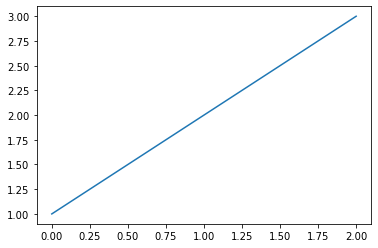

In [83]:
from matplotlib import pyplot as plt
plt.plot([1,2,3])
import numpy as np
import scipy
import scipy.spatial as spatial
import copy
from Environment.Builder_Env import Structure_Builder, circle, assignment
from RL.sac import sac_agent
import matplotlib
import torch
from Environment.data_visualization import show_reset, show_done, show_step, plot_large_frame
from Environment.episode_memory import Episode_Memory
from Environment.createc_control import Createc_Controller

matplotlib.rcParams['image.cmap'] = 'gray'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

In [272]:
import importlib
import Environment.Builder_Env
importlib.reload(Environment.Builder_Env)
from Environment.Builder_Env import Structure_Builder

In [261]:
batch_size= 64
LEARNING_RATE = 0.0003
agent = sac_agent(num_inputs = 4, num_actions = 6, action_space = None, device=device, hidden_size=256, lr=LEARNING_RATE,
                 gamma=0.9, tau=0.005, alpha=1)
weight_folder_name = 'C:/LocalUserData/User-data/phys-asp-lab/auto_manipulation/training_0'

agent.critic.load_state_dict(torch.load('{}/_critic_2500.pth'.format(weight_folder_name)))
agent.policy.load_state_dict(torch.load('{}/_policy_2500.pth'.format(weight_folder_name)))
agent.alpha = torch.load('{}/_alpha_2500.pth'.format(weight_folder_name))
episode_memory = Episode_Memory()

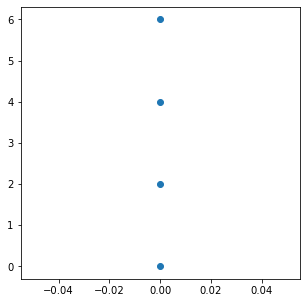

In [275]:
design_nm = np.array(list(zip(np.zeros(4), np.arange(0,8,2))))#np.array([[0, 0], [0, 2.5], [0,1.25]])
plt.subplots(figsize=(5,5))
plt.scatter(design_nm[:,0], design_nm[:,1])

In [276]:
#test offset extration
createc_controller = Createc_Controller(None, None, None, None)
DAC_unit = 2**19
volt_unit = 10
Xgain = float(createc_controller.stm.getparam("GainX"))
Ygain = float(createc_controller.stm.getparam("GainY"))
Xpiezoconst = float(createc_controller.stm.getparam("Xpiezoconst"))
Ypiezoconst = float(createc_controller.stm.getparam("Ypiezoconst"))
x_nm = -0.1*Xpiezoconst*volt_unit*float(createc_controller.stm.getparam('OffsetX'))*Xgain/DAC_unit
y_nm = -0.1*Ypiezoconst*volt_unit*float(createc_controller.stm.getparam('OffsetY'))*Ygain/DAC_unit
print(x_nm, y_nm)

step_nm = 0.4
max_mvolt = 15 #min_mvolt = 0.5*max_mvolt
max_pcurrent_to_mvolt_ratio = 6E3 # min = 0.5*max
goal_nm  = 2
current_jump  = 4
large_len_nm = 16.9
large_offset_nm = np.array([x_nm, y_nm])
pixel = 128
scan_mV = 1000
max_len = 5
env = Structure_Builder(step_nm, max_mvolt, max_pcurrent_to_mvolt_ratio, goal_nm, 
                 current_jump, large_len_nm, large_offset_nm, pixel, scan_mV, max_len)

succeed to connect
250.2965087890625 173.08407592773438
succeed to connect


In [15]:
folder_name = 'C:/LocalUserData/User-data/phys-asp-lab/auto_manipulation/test_build'

The scan will take 32.8 seconds
start: [242.18775488 175.84478556] goal [252.71776749 176.47365645]


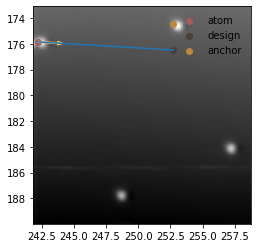

The scan will take 42.6 seconds
anchor from small scan: [252.84430839 174.51979677] anchor from large scan: [252.71776749 174.47365645]


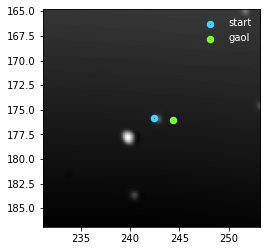

step: 0
66 65 76 66
Old prediction: False
Prediction: 0.49577582
Random scan
The scan will take 42.6 seconds
atom moves by: 0.04789168346445394
precision: 1.894267215261543 nm


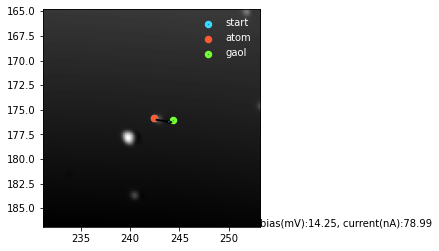

step: 1
68 64 76 66
Old prediction: True
Prediction: 0.43457136
old prediction thinks there is atom movement
The scan will take 42.6 seconds
atom moves by: 0.5714674223678552
precision: 1.379458758886445 nm


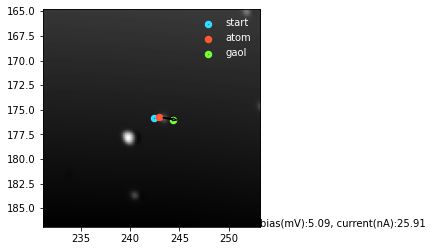

step: 2
67 65 77 66
Old prediction: False
Prediction: 0.45560378
Random scan
The scan will take 42.6 seconds
atom moves by: 0.5714674223678552
precision: 1.379458758886445 nm


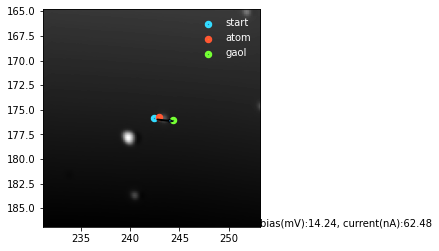

step: 3
67 64 76 66
Old prediction: False
Prediction: 0.47228506
Random scan
The scan will take 42.6 seconds
atom moves by: 0.5739535272727679
precision: 1.3766016243508625 nm


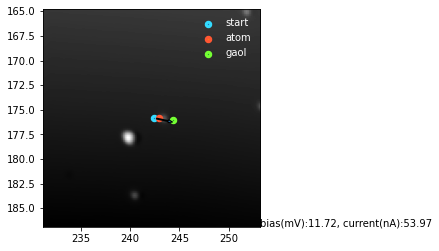

step: 4
68 65 77 66
The scan will take 42.6 seconds
atom moves by: 0.5724718434622558
precision: 1.3776966536847313 nm


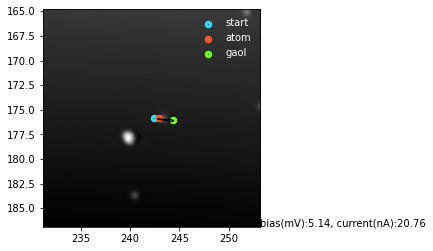

The scan will take 32.8 seconds
start: [242.76312999 175.73245057] goal [252.71776749 176.47365645]


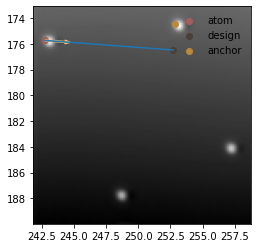

KeyboardInterrupt: 

In [277]:
num_steps = 10

atom_chosen, design_chosen, next_destination_nm, path, anchor_chosen, offset_nm, len_nm = env.reset_large(design_nm)
np.save(folder_name+'/{}_episode_img_info.npy'.format(-1),env.large_img_info)
for i in range(0, num_steps):
    plot_large_frame(env.large_img_info, atom_chosen, design_chosen, anchor_chosen, next_destination_nm, path)
    new_atom_position, dist_destination = RL_operation(env, agent, atom_chosen, next_destination_nm, anchor_chosen, offset_nm, len_nm, i)
    succeed = dist_destination<env.precision_lim
    atom_chosen, design_chosen, next_destination_nm, path, anchor_chosen, offset_nm, len_nm = env.step_large(succeed, new_atom_position)
    
    np.save(folder_name+'/{}_episode_img_info.npy'.format(i), env.large_img_info)

In [266]:
env.obstacle_list

[(239.42848527979538, 177.81006432618767, 1),
 (240.07164666704335, 183.62829939005076, 1),
 (248.64909705696317, 187.7645719099179, 1),
 (242.47442679701456, 175.92295667893455, 1)]

In [264]:
env.atom_chosen

array([253.01742526, 174.61146244])

In [265]:
env.design_chosen

array([242.4744268 , 176.92295668])

In [231]:
img_forward, img_backward, offset_nm, len_nm = env.createc_controller.scan_image()

The scan will take 21.6 seconds


In [258]:
def blob_detection(img):
    ###set BlobDetector params https://learnopencv.com/blob-detection-using-opencv-python-c/
    img = np.array(img)
    img = (255*((img-np.min(img))/(np.max(img)-np.min(img)))).astype('uint8')
    #kernel = np.ones((3,3),np.float32)/9
    #img = cv2.filter2D(img,-1,kernel)
    #pdb.set_trace()
    #plt.imshow(img)
    params = cv2.SimpleBlobDetector_Params()
    params.filterByInertia = False
    params.filterByCircularity = False
    params.filterByConvexity = False
    #params.minInertiaRatio = 0.7
    params.maxThreshold = 255
    params.minThreshold = 40
    params.blobColor = 255
    params.filterByArea = False
    params.minArea = 1
    params.maxArea = 1000
    params.minDistBetweenBlobs = 10
    ###create BlobDetector
    detector = cv2.SimpleBlobDetector_create(params)
    ###Detect
    keypoints = detector.detect(img)
    #im_with_keypoints = cv2.drawKeypoints(img, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    atoms_pixel = []
    atoms_size = []
    for k in keypoints:
        atoms_pixel.append(k.pt)
        atoms_size.append(k.size)
    atoms_pixel = np.array(atoms_pixel)
    atoms_size = np.array(atoms_size)
    return atoms_pixel, atoms_size

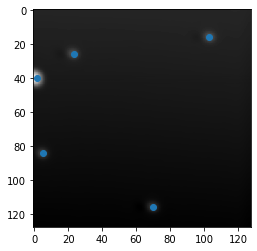

In [259]:
b, _ = blob_detection(img_backward)
plt.imshow(img_backward)
plt.scatter(b[:,0], b[:,1])

In [225]:
import cv2
def blob_detection(img):
    ###set BlobDetector params https://learnopencv.com/blob-detection-using-opencv-python-c/
    img = np.array(img)
    img = (255*((img-np.min(img))/(np.max(img)-np.min(img)))).astype('uint8')
    #kernel = np.ones((3,3),np.float32)/9
    #img = cv2.filter2D(img,-1,kernel)
    #pdb.set_trace()
    #plt.imshow(img)
    params = cv2.SimpleBlobDetector_Params()
    params.filterByInertia = False
    params.filterByCircularity = False
    params.filterByConvexity = False
    #params.minInertiaRatio = 0.7
    params.maxThreshold = 255
    params.minThreshold = 50
    params.blobColor = 255
    params.filterByArea = True
    params.minArea = 1
    params.maxArea = 1000
    params.minDistBetweenBlobs = 10
    ###create BlobDetector
    detector = cv2.SimpleBlobDetector_create(params)
    ###Detect
    keypoints = detector.detect(img)
    #im_with_keypoints = cv2.drawKeypoints(img, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    atoms_pixel = []
    atoms_size = []
    for k in keypoints:
        atoms_pixel.append(k.pt)
        atoms_size.append(k.size)
    atoms_pixel = np.array(atoms_pixel)
    atoms_size = np.array(atoms_size)
    return atoms_pixel, atoms_size

In [226]:
a, b = blob_detection(img_forward)

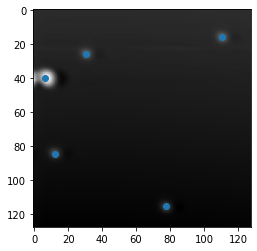

In [227]:
plt.imshow(img_forward)
plt.scatter(a[:,0], a[:,1])

In [169]:
def RL_operation(env, agent, atom_chosen, next_destination_nm, anchor_chosen, offset_nm, len_nm, i_episode, max_steps=5):
    done = False
    state, info = env.reset(next_destination_nm, anchor_chosen, offset_nm, len_nm, large_len_nm)
        
    show_reset(env.img_info, env.atom_start_absolute_nm, env.destination_absolute_nm)
    episode_memory.update_memory_reset(env.img_info, i_episode, info)
    
    for step in range(max_steps):
        print('step:', step)
        if np.linalg.norm(env.atom_absolute_nm - atom_chosen)>2:
            print('identify the wrong atom')
            break
            
        action = agent.select_action(state)
        next_state, reward, done, info = env.step(action)
        mask = float(not done)
        episode_memory.update_memory_step(state, action, next_state, reward, done, info)
        state=next_state
        print('precision:', env.dist_destination, 'nm')
        show_step(env.img_info, info['start_nm']+env.atom_absolute_nm, info['end_nm']+env.atom_absolute_nm,env.atom_absolute_nm, 
                  env.atom_start_absolute_nm, env.destination_absolute_nm, 
                  action[4]*env.max_mvolt, action[5]*env.max_pcurrent_to_mvolt_ratio*action[4]*env.max_mvolt)
        if done:
            episode_memory.update_memory_done(env.img_info, env.atom_absolute_nm, np.array([0,0]))
            episode_memory.save_memory(folder_name)
            break
    return env.atom_absolute_nm, env.dist_destination